In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, GRU
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Load synthetic data from CSV file
df = pd.read_csv("Datasets/Synthetic_data_with_OEE_MME_16_06_24(in).csv")

# Convert 'Date' column to datetime if it's not already in datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Calculate MME (Machine Mechanical Efficiency)
df["MME"] = df["General_Running_Time"] / df["Effective_Running_Time"]

# Calculate OEE (Overall Equipment Effectiveness)
# df["Q"] = 1 - (df["Waste_Packages"] / (df["Waste_Packages"] + df["Good_Packages"]))  # Quality
# df["P"] = 1 - ((df["Nominal_Speed"] - df["Actual_Speed"]) / df["Nominal_Speed"])  # Performance
# df["A"] = 1 - ((df["Ancillary_Time"] + df["Internal_Downtime"] + df["External_Downtime"]) / df["Base_Working_Time"])# Availability
df["OEE"] = df["Q"] * df["P"] * df["A"]  # Q=Quality, P=Performance, A=Availability

In [2]:
# Normalize features
scaler = MinMaxScaler()
df[['Effective_Running_Time', 'General_Running_Time', 'Ancillary_Time', 'Internal_Downtime', 'External_Downtime', 'Waste_Packages', 'Good_Packages', 'Nominal_Speed', 'Actual_Speed']] = scaler.fit_transform(df[['Effective_Running_Time', 'General_Running_Time', 'Ancillary_Time', 'Internal_Downtime', 'External_Downtime', 'Waste_Packages', 'Good_Packages', 'Nominal_Speed', 'Actual_Speed']])

# Prepare data for training
X = df[['Effective_Running_Time', 'General_Running_Time', 'Ancillary_Time', 'Internal_Downtime', 'External_Downtime', 'Waste_Packages', 'Good_Packages', 'Nominal_Speed', 'Actual_Speed']].values
y = df[['MME', 'OEE']].values
dates = df['Date'].values  # Save dates for plotting

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Conv1D model
conv1d_model = Sequential([
    Input(shape=(9, 1)),  # Define the input shape using Input layer
    Conv1D(filters=64, kernel_size=2, activation='relu'),  # Adjust kernel_size to 2
    MaxPooling1D(pool_size=1),  # Pooling size adjusted for the small input
    Flatten(),
    Dense(50, activation='relu'),
    Dense(2)
])

# Compile the Conv1D model
conv1d_model.compile(optimizer="adam", loss="mse")

In [4]:
#Reshape input data for Conv1D
X_train_conv1d = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_conv1d = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train the Conv1D model
conv1d_model.fit(X_train_conv1d, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test_conv1d, y_test))

# Predict on test set with Conv1D model
y_pred_conv1d = conv1d_model.predict(X_test_conv1d)

# Separate predictions for MME and OEE
y_pred_MME_conv1d = y_pred_conv1d[:, 0]  # First column for MME
y_pred_OEE_conv1d = y_pred_conv1d[:, 1]  # Second column for OEE

# Normalize the feature data for GRU
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize the target data for GRU
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Split into training and testing sets for GRU
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X_scaled, y_scaled, dates, test_size=0.2, random_state=42)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6690 - val_loss: 0.0587
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0746 - val_loss: 0.0484
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0472 - val_loss: 0.0456
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0395 - val_loss: 0.0364
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0321 - val_loss: 0.0294
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0245 - val_loss: 0.0220
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0180 - val_loss: 0.0167
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0158 - val_loss: 0.0133
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_l

In [5]:
# Function to create sequences for the GRU model
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps - 1])
    return np.array(Xs), np.array(ys)

time_steps = 5
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

# Adjust dates for sequences
def adjust_dates(dates, time_steps):
    return dates[time_steps-1:]

dates_train_seq = adjust_dates(dates_train, time_steps)
dates_test_seq = adjust_dates(dates_test, time_steps)

# Verify the lengths to ensure they match
print(f'X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}')
print(f'X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}')
print(f'dates_train_seq length: {len(dates_train_seq)}, dates_test_seq length: {len(dates_test_seq)}')


X_train_seq shape: (433, 5, 9), y_train_seq shape: (433, 2)
X_test_seq shape: (106, 5, 9), y_test_seq shape: (106, 2)
dates_train_seq length: 433, dates_test_seq length: 106


In [6]:
# Define the GRU model with separate outputs for OEE and MME
input_layer = Input(shape=(time_steps, X_train_seq.shape[2]))
gru_layer = GRU(64, return_sequences=True)(input_layer)
gru_layer = GRU(32)(gru_layer)

# Output layers for OEE and MME
output_oee = Dense(1, name='oee_output')(gru_layer)
output_mme = Dense(1, name='mme_output')(gru_layer)

gru_model = Model(inputs=input_layer, outputs=[output_oee, output_mme])

# Compile the GRU model
gru_model.compile(optimizer='adam', loss='mse')

# Train the GRU model
history = gru_model.fit(
    X_train_seq,
    {'oee_output': y_train_seq[:, 0], 'mme_output': y_train_seq[:, 1]},
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the GRU model
loss = gru_model.evaluate(X_test_seq,
                      {'oee_output': y_test_seq[:, 0], 'mme_output': y_test_seq[:, 1]},
                      verbose=1)
print(f'Test loss: {loss}')

# Predict with the GRU model
y_pred_oee_gru, y_pred_mme_gru = gru_model.predict(X_test_seq)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 2.0838 - val_loss: 1.9174
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6466 - val_loss: 1.7182
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3947 - val_loss: 1.5099
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2349 - val_loss: 1.2791
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9312 - val_loss: 1.0149
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7185 - val_loss: 0.7126
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5258 - val_loss: 0.4099
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2423 - val_loss: 0.1697
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0920 - val_loss: 0.0714
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0535 - val_loss: 0.0566
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0421 - val_loss: 0.0553
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0297

In [7]:
# Inverse transform the predictions from GRU model
y_pred_oee_inverse_gru = scaler_y.inverse_transform(np.column_stack([y_pred_oee_gru, np.zeros(y_pred_oee_gru.shape)]))[:, 0]
y_pred_mme_inverse_gru = scaler_y.inverse_transform(np.column_stack([np.zeros(y_pred_mme_gru.shape), y_pred_mme_gru]))[:, 1]

y_test_oee_inverse = scaler_y.inverse_transform(np.column_stack([y_test_seq[:, 0], np.zeros(y_test_seq[:, 0].shape)]))[:, 0]
y_test_mme_inverse = scaler_y.inverse_transform(np.column_stack([np.zeros(y_test_seq[:, 1].shape), y_test_seq[:, 1]]))[:, 1]

# Inverse transform the predictions of the Conv1D model for comparison
y_pred_MME_inverse_conv1d = scaler_y.inverse_transform(np.column_stack([np.zeros(y_pred_MME_conv1d.shape), y_pred_MME_conv1d]))[:, 1]
y_pred_OEE_inverse_conv1d = scaler_y.inverse_transform(np.column_stack([y_pred_OEE_conv1d, np.zeros(y_pred_OEE_conv1d.shape)]))[:, 0]

# Custom function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate evaluation metrics for OEE
rmse_oee = np.sqrt(mean_squared_error(y_test_oee_inverse, y_pred_oee_inverse_gru))
mae_oee = mean_absolute_error(y_test_oee_inverse, y_pred_oee_inverse_gru)
mape_oee = mean_absolute_percentage_error(y_test_oee_inverse, y_pred_oee_inverse_gru)

print(f'OEE - RMSE: {rmse_oee}')
print(f'OEE - MAE: {mae_oee}')
print(f'OEE - MAPE: {mape_oee}')

OEE - RMSE: 0.027675544935218503
OEE - MAE: 0.02009326269283659
OEE - MAPE: 1.5532718665598417


In [8]:
# Calculate evaluation metrics for MME
rmse_mme = np.sqrt(mean_squared_error(y_test_mme_inverse, y_pred_mme_inverse_gru))
mae_mme = mean_absolute_error(y_test_mme_inverse, y_pred_mme_inverse_gru)
mape_mme = mean_absolute_percentage_error(y_test_mme_inverse, y_pred_mme_inverse_gru)

print(f'MME - RMSE: {rmse_mme}')
print(f'MME - MAE: {mae_mme}')
print(f'MME - MAPE: {mape_mme}')

MME - RMSE: 0.0070762539884827525
MME - MAE: 0.005298094556080476
MME - MAPE: 0.843588422690083


In [10]:
# Function to plot the comparison graphs
def plot_comparison(dates, actual, pred_conv1d, pred_gru, title, ylabel):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual', color='blue')
    plt.plot(dates, pred_conv1d, label='Conv1D Prediction', color='red')
    plt.plot(dates, pred_gru, label='GRU Prediction', color='green')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


ValueError: x and y must have same first dimension, but have shapes (106,) and (110,)

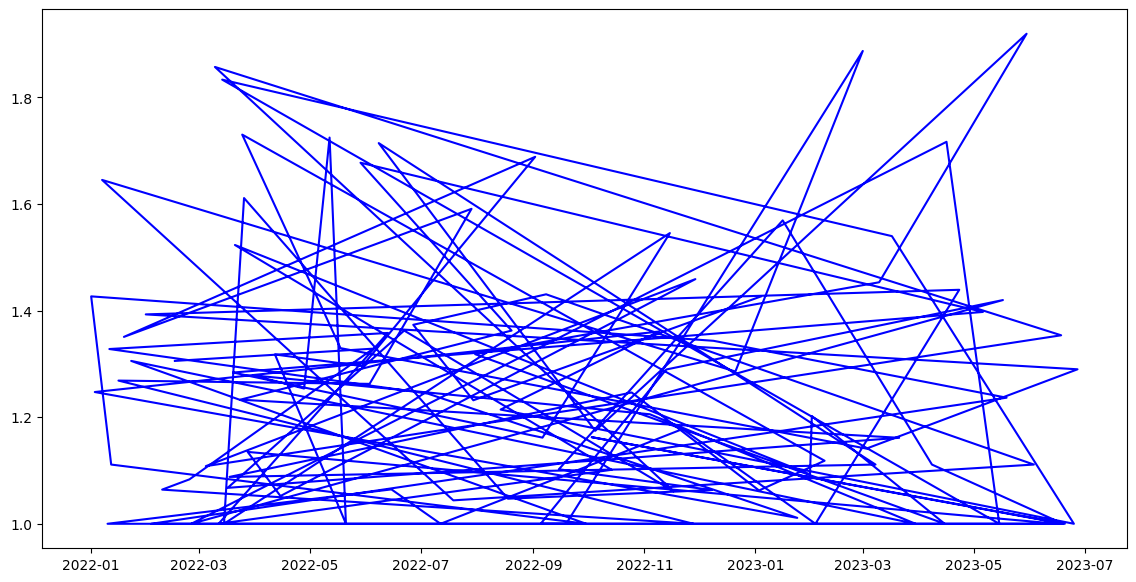

In [11]:
# Plot comparison for OEE
plot_comparison(
    dates_test_seq,
    y_test_oee_inverse,
    y_pred_OEE_inverse_conv1d,
    y_pred_oee_inverse_gru,
    title='OEE Comparison: Actual vs Conv1D vs GRU',
    ylabel='OEE'
)

# Plot comparison for MME
plot_comparison(
    dates_test_seq,
    y_test_mme_inverse,
    y_pred_MME_inverse_conv1d,
    y_pred_mme_inverse_gru,
    title='MME Comparison: Actual vs Conv1D vs GRU',
    ylabel='MME'
)